# Multi-Task Learning (MTL) Strategies on MNIST Digits

This notebook provides a hands-on comparison of different approaches to Multi-Task Learning (MTL) using a simple Multi-Layer Perceptron (MLP) architecture on the MNIST dataset. We will investigate:

1.  **Single-Task Learning (STL):** Training independent models for each task.
2.  **Hard Parameter Sharing:** Sharing initial layers across tasks.
3.  **Soft Parameter Sharing (Cross-Stitch Networks):** Learning to combine task-specific activations.

**Tasks:** Binary classification on MNIST digits: "Is Even?" and "Is Multiple of 3?".

---

## 1. Setup and Global Configurations

We begin by importing the necessary libraries and defining global configurations, including the device for computation (CPU for broader compatibility, though GPU will be used if available), batch size, learning rate, and number of training epochs.

### 1.1 Imports and Device Setup

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import time
import random
import pandas as pd

# Hyperparameters for training
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
SEED = 42

In [134]:
# Set a seed for reproducibility
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Select the execution device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Selected device: {device}")


# --- Mixed Precision Setup ---
use_amp = device.type == 'cuda'

scaler = torch.amp.GradScaler(device, enabled=use_amp)

Selected device: cuda


---

## 2. Custom Dataset Preparation

To demonstrate multi-task learning, we will create a custom dataset from MNIST that generates labels for two distinct binary classification tasks: determine if a digit is even, and if it is a multiple of 3 (excluding zero).

The `MNISTCustomTasks` class inherits from `torch.utils.data.Dataset`, which is the base class for datasets in PyTorch. Custom datasets are required to implement `__len__` (to return the dataset size) and `__getitem__` (to return a sample by its index).

Standard transformations are applied to the MNIST images, including converting them to PyTorch tensors and normalizing their pixel values. The labels will be formatted as float tensors suitable for `BCEWithLogitsLoss`.

### 2.1 MNISTCustomTasks Class

In [135]:
class MNISTCustomTasks(Dataset): # Inherits from torch.utils.data.Dataset: Base class for datasets. Custom datasets must override __len__ and __getitem__.
    """
    A custom Dataset class to create two binary classification tasks from MNIST:
    Task 1: Is the digit Even (0) or Odd (1)?
    Task 2: Is the digit a Multiple of 3 (excluding 0) (1) or Not (0)?
    Labels are returned as float tensors for BCEWithLogitsLoss.
    """
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        # The length of our custom dataset is the same as the original MNIST dataset.
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        # Get the image and original label from MNIST.
        image, label = self.mnist_dataset[idx]

        # Task 1: Is Even? (0 for Even, 1 for Odd)
        task1_label_val = 0 if label % 2 == 0 else 1
        # Task 2: Is Multiple of 3 (excluding 0)? (0 for No, 1 for Yes)
        task2_label_val = 1 if label % 3 == 0 and label != 0 else 0

        # Return the image and the labels for both tasks as float tensors of shape [1].
        return image, torch.tensor([task1_label_val], dtype=torch.float), torch.tensor([task2_label_val], dtype=torch.float)

### 2.2 Transformations and DataLoaders

This section defines the image transformations and prepares the `DataLoader` instances for training and testing. `DataLoader` provides an efficient way to iterate over the dataset in batches, with options for shuffling and parallel data loading.

In [136]:
# Define standard transformations for MNIST images.
transform = transforms.Compose([ # torchvision.transforms.Compose: Chains multiple image transformations together.
    transforms.ToTensor(), # torchvision.transforms.ToTensor: Converts a PIL Image or NumPy array to a PyTorch Tensor, scaling pixel values to [0.0, 1.0].
    transforms.Normalize((0.1307,), (0.3081,)) # torchvision.transforms.Normalize: Normalizes a tensor image with mean and standard deviation. This is critical for stable training.
])

# Download and prepare the MNIST datasets.
# torchvision.datasets.MNIST: A Dataset class for the MNIST dataset, handling download and loading.
train_mnist = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create our custom task datasets from MNIST.
train_dataset = MNISTCustomTasks(train_mnist)
test_dataset = MNISTCustomTasks(test_mnist)

# Create DataLoaders to efficiently load data in batches.
# torch.utils.data.DataLoader: An iterator that provides efficient batching, shuffling, and multi-process data loading from a Dataset.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

---

## 3. Model Architectures

We define a base MLP architecture and then implement three distinct models: Single-Task Learning (STL), Hard Parameter Sharing for MTL, and Cross-Stitch Networks for Soft Parameter Sharing. 

### 3.1 Base MLP Architecture (`MLP`)

This `MLP` serves as the fundamental building block for our models. It is a simple feed-forward neural network with two hidden layers and a single output unit, suitable for binary classification tasks when combined with a sigmoid activation (which is handled by `BCEWithLogitsLoss`).

In [137]:
class MLP(nn.Module): # Inherits from torch.nn.Module: Base class for all neural network modules. Manages parameters and child modules.
    """
    A simple, fixed Multi-Layer Perceptron (MLP) architecture.
    Used as the base for Single-Task Learning models and as a component in MTL models.
    Outputs a single logit for binary classification.
    """
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128, num_classes=1):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten() # torch.nn.Flatten: Flattens the input tensor (e.g., image) into a 1D vector.
                                    # Explanation: This layer is crucial for preparing multi-dimensional input data,
                                    # such as images (which are typically 2D or 3D, e.g., [channels, height, width]),
                                    # to be fed into fully connected (linear) layers. Fully connected layers expect
                                    # a 1D vector of features for each sample. `nn.Flatten()` reshapes the input
                                    # into a single long vector while keeping the batch dimension intact.
                                    # For example, a 28x28 grayscale image (input size 784) will be flattened from
                                    # [batch_size, 1, 28, 28] to [batch_size, 784].
        self.fc1 = nn.Linear(input_size, hidden_size1) # torch.nn.Linear: Implements a linear transformation (fully connected layer): y = xW^T + b.
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) # torch.nn.Linear
        self.fc3 = nn.Linear(hidden_size2, num_classes) # torch.nn.Linear - Output layer with a single unit for binary classification (logit).
        self.relu = nn.ReLU() # torch.nn.ReLU: Rectified Linear Unit activation function; introduces non-linearity.


    def forward(self, x): # The forward method defines how data flows through the network. Automatically called on model(input).
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        output = self.fc3(x)
        return output

### 3.2 Single-Task Learning Model (`STLModel`)

The `STLModel` is a straightforward wrapper around our `MLP`. For single-task learning, an independent instance of this model will be trained for each task.

In [138]:
class STLModel(nn.Module): # Inherits from torch.nn.Module
    """
    Wrapper for a Single-Task Learning (STL) model.
    It utilizes the MLP for a specific task, outputting a single logit.
    """
    def __init__(self, input_size, num_classes=1):
        super(STLModel, self).__init__()
        self.mlp = MLP(input_size, num_classes=num_classes)

    def forward(self, x):
        return self.mlp(x)

### 3.3 Hard Parameter Sharing MTL Model (`HardSharedMLP`)

This model implements a "hard" parameter sharing strategy. The initial layers of the network are shared across both tasks, learning common representations. Subsequently, task-specific layers (heads) branch off from these shared layers to make predictions for each task. Each task head outputs a single logit.

In [139]:
class HardSharedMLP(nn.Module): # Inherits from torch.nn.Module
    """
    Multi-Task Learning (MTL) model with Hard Parameter Sharing.
    Initial layers are shared across both tasks, then separate "heads"
    handle task-specific predictions, each outputting a single logit.
    """
    def __init__(self, input_size, shared_hidden_size=256, task_hidden_size=128, num_classes_task1=1, num_classes_task2=1):
        super(HardSharedMLP, self).__init__()
        self.flatten = nn.Flatten()

        # Shared layers: these layers learn features common to both tasks.
        self.shared_fc1 = nn.Linear(input_size, shared_hidden_size)
        self.shared_fc2 = nn.Linear(shared_hidden_size, task_hidden_size)

        # Task 1 specific head: processes shared features for Task 1.
        self.task1_output = nn.Linear(task_hidden_size, num_classes_task1)

        # Task 2 specific head: processes shared features for Task 2.
        self.task2_output = nn.Linear(task_hidden_size, num_classes_task2)

        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.flatten(x)

        # Pass input through shared layers.
        shared_features = self.relu(self.shared_fc1(x))
        shared_features = self.relu(self.shared_fc2(shared_features))

        # Pass shared features through task-specific heads.
        task1_out = self.task1_output(shared_features)
        task2_out = self.task2_output(shared_features)

        return task1_out, task2_out

### 3.4 Cross-Stitch Layer (`CrossStitchUnit`)

The `CrossStitchUnit` is the fundamental component for Soft Parameter Sharing in Cross-Stitch Networks. It enables the network to learn an optimal linear combination of feature maps from different task-specific branches at specified layers.

In [140]:
class CrossStitchUnit(nn.Module): # Inherits from torch.nn.Module
    """
    A Cross-Stitch Layer for Soft Parameter Sharing.
    It learns a linear combination of feature maps from different tasks.
    """
    def __init__(self, num_features):
        super(CrossStitchUnit, self).__init__()
        self.alpha = nn.Parameter(torch.tensor([[0.5, 0.5], [0.5, 0.5]], dtype=torch.float32)) 

    def forward(self, x1, x2):
        # The output for task 1 is a linear combination of its own features (x1)
        # and features from task 2 (x2), scaled by the learned alpha parameters. Similarly for task 2.
        alpha = torch.softmax(self.alpha, dim=1) # Softmax along the rows (dim=1)

        out_1 = alpha[0,0] * x1 + alpha[0,1] * x2
        out_2 = alpha[1,0] * x1 + alpha[1,1] * x2
        return out_1, out_2

### 3.5 Cross-Stitch Networks MTL Model (`CrossStitchMLP`)

Cross-Stitch Networks employ a Soft Parameter Sharing approach, these networks learn to combine feature maps (activations) from task-specific branches. This combination is achieved using learned scalar weights ($\alpha$) within `CrossStitchUnit` modules, which are placed after each Relu for both the linear layers of the task-specific networks. This architecture allows for a more flexible and adaptive flow of information between tasks.

- For two-task learning, the cross-stitch unit is $2 \times 2$ matrix, and it works as follows:

$$
\begin{bmatrix} \tilde{x}_A^{(l)} \\ \tilde{x}_B^{(l)} \end{bmatrix} =
\begin{bmatrix} \alpha_{AA}^{(l)} & \alpha_{AB}^{(l)} \\ \alpha_{BA}^{(l)} & \alpha_{BB}^{(l)} \end{bmatrix}
\begin{bmatrix} x_A^{(l)} \\ x_B^{(l)} \end{bmatrix}
$$

Where:

* **$\alpha_{AA}^{(l)}$ and $\alpha_{BB}^{(l)}$ (Same-Task Weights):** Control how much of the original information from Task A ($x_A^{(l)}$) remains within Branch A, and similarly for Task B ($x_B^{(l)}$) within Branch B.
* **$\alpha_{AB}^{(l)}$ and $\alpha_{BA}^{(l)}$ (Different-Task Weights):** Control the information exchange *between* the two tasks. Specifically, $\alpha_{AB}^{(l)}$ determines how much of Task B's information ($x_B^{(l)}$) is incorporated into Task A's updated features ($\tilde{x}_A^{(l)}$). Conversely, $\alpha_{BA}^{(l)}$ controls how much of Task A's information ($x_A^{(l)}$) influences Task B's updated features ($\tilde{x}_B^{(l)}$).

This operation is typically applied element-wise across the activation tensors if `num_features` in `CrossStitchUnit` corresponds to the feature dimension of the activations.

In [141]:
class CrossStitchMLP(nn.Module): # Inherits from torch.nn.Module
    """
    Multi-Task Learning (MTL) model using Cross-Stitch Networks.
    Each task has its own MLP branch, but Cross-Stitch units are inserted
    between corresponding layers to allow learned information sharing.
    Each task head outputs a single logit.

    Architectural Overview:
    - Shared Input Processing: A common flattening layer for all inputs.
    - Task-Specific Feature Extractors: Independent MLP branches for each task (Task 1 and Task 2).
    - Learned Information Sharing: Cross-Stitch units strategically placed between layers
      of the task-specific branches to enable learned linear combinations of features.
    - Task-Specific Output Heads: Final linear layers that produce a single logit for each task.
    """
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128, num_classes_task1=1, num_classes_task2=1):
        super(CrossStitchMLP, self).__init__()

        # --- Input Processing Layer ---
        # This layer is applied universally to flatten the input image.
        self.flatten = nn.Flatten()

        # --- Task 1 Specific MLP Layers ---
        # These layers form the independent branch for Task 1.
        self.task1_fc1 = nn.Linear(input_size, hidden_size1)
        self.task1_fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.task1_output = nn.Linear(hidden_size2, num_classes_task1)

        # --- Task 2 Specific MLP Layers ---
        # These layers form the independent branch for Task 2.
        self.task2_fc1 = nn.Linear(input_size, hidden_size1)
        self.task2_fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.task2_output = nn.Linear(hidden_size2, num_classes_task2)

        # --- Cross-Stitch Units for Inter-Task Communication ---
        # These units are inserted between corresponding layers of the task-specific MLPs.
        # They learn how much information to share between the branches.
        self.cross_stitch1 = CrossStitchUnit(hidden_size1) # Applied after the first hidden layer of each task branch.
        self.cross_stitch2 = CrossStitchUnit(hidden_size2) # Applied after the second hidden layer of each task branch.

        # --- Activation Function ---
        # ReLU is used consistently across all hidden layers.
        self.relu = nn.ReLU()

    def forward(self, x):
        # --- Stage 1: Flatten Input ---
        # The input 'x' (e.g., [batch_size, 1, 28, 28]) is flattened.
        # This flattened input is the starting point for both task-specific pathways.
        x_flat = self.flatten(x)

        # --- Stage 2: First Hidden Layer Processing (Task-Specific Pathways) ---
        # Each task processes the flattened input through its first dedicated linear layer followed by ReLU activation.
        # Pathway for Task 1:
        features_t1_l1 = self.relu(self.task1_fc1(x_flat)) # Shape: [batch_size, hidden_size1]
        # Pathway for Task 2:
        features_t2_l1 = self.relu(self.task2_fc1(x_flat)) # Shape: [batch_size, hidden_size1]

        # --- Stage 3: Cross-Stitch Mixing (After First Hidden Layer) ---
        # The outputs from the first hidden layers of both tasks are fed into
        # the first Cross-Stitch unit. This unit learns to optimally combine features
        # from both tasks, producing refined features for the subsequent layer of each task.
        mixed_features_t1_l1, mixed_features_t2_l1 = self.cross_stitch1(features_t1_l1, features_t2_l1)

        # --- Stage 4: Second Hidden Layer Processing (Task-Specific Pathways) ---
        # The mixed features from the first Cross-Stitch unit are then processed
        # by the second dedicated linear layer for each task, followed by ReLU activation.
        # Pathway for Task 1:
        features_t1_l2 = self.relu(self.task1_fc2(mixed_features_t1_l1)) # Shape: [batch_size, hidden_size2]
        # Pathway for Task 2:
        features_t2_l2 = self.relu(self.task2_fc2(mixed_features_t2_l1)) # Shape: [batch_size, hidden_size2]

        # --- Stage 5: Cross-Stitch Mixing (After Second Hidden Layer) ---
        # Similar to Stage 3, the outputs from the second hidden layers are
        # again mixed by the second Cross-Stitch unit.
        mixed_features_t1_l2, mixed_features_t2_l2 = self.cross_stitch2(features_t1_l2, features_t2_l2)

        # --- Stage 6: Task-Specific Output Layers ---
        # The final mixed features are passed through their respective output layers
        # to produce the logits (raw scores before sigmoid) for each task.
        task1_out = self.task1_output(mixed_features_t1_l2) # Shape: [batch_size, num_classes_task1 (which is 1)]
        task2_out = self.task2_output(mixed_features_t2_l2) # Shape: [batch_size, num_classes_task2 (which is 1)]

        return task1_out, task2_out

---

## 4. Training and Evaluation Functions

This section provides functions that encapsulate the core logic for:
1.  Training a model over multiple epochs while tracking performance metrics.
2.  Evaluating a trained model's performance on the test set.
3.  Collecting predictions for subsequent analysis, such as confusion matrix visualization.

The loss function used will be `BCEWithLogitsLoss`.

In [142]:
def evaluate_model(model, loader, criterion, model_type="STL"):
    """
    Evaluates a trained model on a given data loader.
    Calculates loss and accuracy for the relevant tasks using BCEWithLogitsLoss.
    The model output is a logit, target is a float (0.0 or 1.0).
    """
    model.eval() # model.eval(): Sets the module to evaluation mode. This disables dropout and freezes BatchNorm statistics, crucial for consistent evaluation.
    total_loss = 0
    correct_task1 = 0
    correct_task2 = 0
    total_samples = 0

    with torch.no_grad(): # torch.no_grad(): A context manager that disables gradient calculation, saving memory and speeding up inference.
        for data, target_task1, target_task2 in loader:
            data = data.to(device)
            target_task1 = target_task1.to(device) # Shape: [batch_size, 1], dtype: float
            target_task2 = target_task2.to(device) # Shape: [batch_size, 1], dtype: float

            if model_type == "STL_Task1":
                output = model(data) # Output shape: [batch_size, 1] (logits)
                loss = criterion(output, target_task1)
                preds_task1 = (torch.sigmoid(output).squeeze() > 0.5).long() # Predictions: 0 or 1
                correct_task1 += (preds_task1 == target_task1.squeeze().long()).sum().item()
            elif model_type == "STL_Task2":
                output = model(data) # Output shape: [batch_size, 1] (logits)
                loss = criterion(output, target_task2)
                preds_task2 = (torch.sigmoid(output).squeeze() > 0.5).long() # Predictions: 0 or 1
                correct_task2 += (preds_task2 == target_task2.squeeze().long()).sum().item()
            elif model_type == "MTL_Hard" or model_type == "MTL_CrossStitch":
                output_task1, output_task2 = model(data) # Output shapes: [batch_size, 1] (logits)
                loss_task1 = criterion(output_task1, target_task1)
                loss_task2 = criterion(output_task2, target_task2)
                loss = loss_task1 + loss_task2 # Sum of losses for Multi-Task Learning.

                preds_task1 = (torch.sigmoid(output_task1).squeeze() > 0.5).long()
                preds_task2 = (torch.sigmoid(output_task2).squeeze() > 0.5).long()
                correct_task1 += (preds_task1 == target_task1.squeeze().long()).sum().item()
                correct_task2 += (preds_task2 == target_task2.squeeze().long()).sum().item()
            else:
                raise ValueError("Invalid model_type specified for evaluation.")

            total_loss += loss.item()
            total_samples += data.size(0)

    avg_loss = total_loss / len(loader)
    acc_task1 = (correct_task1 / total_samples) * 100 if model_type != "STL_Task2" else 0.0
    acc_task2 = (correct_task2 / total_samples) * 100 if model_type != "STL_Task1" else 0.0
    return avg_loss, acc_task1, acc_task2

In [143]:
def train_model(model, loader, optimizer, criterion, model_type="STL", num_epochs=NUM_EPOCHS):
    """
    Trains a given model and tracks training/validation metrics.
    Supports STL (Single-Task Learning) and MTL (Multi-Task Learning) models.
    Uses BCEWithLogitsLoss for binary classification.
    """
    history = {'train_loss': [], 'train_acc_task1': [], 'train_acc_task2': [],
               'val_loss': [], 'val_acc_task1': [], 'val_acc_task2': []}
    best_val_accuracy = {'task1': 0.0, 'task2': 0.0, 'overall': 0.0} # To save the best performing model.

    if model_type == "MTL_CrossStitch":
        history['alphas'] = {
            'cs1_alpha00': [], 'cs1_alpha01': [], 
            'cs1_alpha10': [], 'cs1_alpha11': [],
            'cs2_alpha00': [], 'cs2_alpha01': [], 
            'cs2_alpha10': [], 'cs2_alpha11': [] 
        }

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train() # model.train(): Sets the module to training mode. This affects layers like BatchNorm and Dropout.
        total_loss = 0
        correct_task1 = 0
        correct_task2 = 0
        total_samples = 0

        for data, target_task1, target_task2 in loader:
            data = data.to(device) # .to(device): Moves a tensor or Module's parameters/buffers to the specified device (CPU/GPU).
            target_task1 = target_task1.to(device) # Shape: [batch_size, 1], dtype: float
            target_task2 = target_task2.to(device) # Shape: [batch_size, 1], dtype: float

            optimizer.zero_grad() # optimizer.zero_grad(): Clears the gradients of all optimized tensors. Gradients accumulate by default in PyTorch.

            if model_type == "STL_Task1":
                output = model(data) # Output shape: [batch_size, 1] (logits)
                loss = criterion(output, target_task1)
                preds_task1 = (torch.sigmoid(output).squeeze() > 0.5).long() # .squeeze() removes dimensions of size 1. .long() converts boolean to long (0 or 1).
                correct_task1 += (preds_task1 == target_task1.squeeze().long()).sum().item() # .item(): Extracts the scalar value from a 0-dimensional tensor.
            elif model_type == "STL_Task2":
                output = model(data)
                loss = criterion(output, target_task2)
                preds_task2 = (torch.sigmoid(output).squeeze() > 0.5).long()
                correct_task2 += (preds_task2 == target_task2.squeeze().long()).sum().item()
            elif model_type == "MTL_Hard" or model_type == "MTL_CrossStitch":
                output_task1, output_task2 = model(data)
                loss_task1 = criterion(output_task1, target_task1)
                loss_task2 = criterion(output_task2, target_task2)
                loss = loss_task1 + loss_task2 # Sum of losses for Multi-Task Learning.

                preds_task1 = (torch.sigmoid(output_task1).squeeze() > 0.5).long()
                preds_task2 = (torch.sigmoid(output_task2).squeeze() > 0.5).long()
                correct_task1 += (preds_task1 == target_task1.squeeze().long()).sum().item()
                correct_task2 += (preds_task2 == target_task2.squeeze().long()).sum().item()
            else:
                raise ValueError("Invalid model_type specified for training.")

            loss.backward() # .backward(): Computes the gradient of the loss with respect to all parameters that require gradients (backpropagation).
            optimizer.step() # optimizer.step(): Performs a single optimization step (updates model parameters based on gradients).
            total_loss += loss.item()
            total_samples += data.size(0)

        # Calculate average training metrics for the epoch.
        avg_train_loss = total_loss / len(loader)
        train_acc_task1 = (correct_task1 / total_samples) * 100 if model_type != "STL_Task2" else 0.0
        train_acc_task2 = (correct_task2 / total_samples) * 100 if model_type != "STL_Task1" else 0.0

        history['train_loss'].append(avg_train_loss)
        history['train_acc_task1'].append(train_acc_task1)
        history['train_acc_task2'].append(train_acc_task2)

        # Validation step: evaluate model performance on the test set.
        val_loss, val_acc_task1, val_acc_task2 = evaluate_model(model, test_loader, criterion, model_type)
        history['val_loss'].append(val_loss)
        history['val_acc_task1'].append(val_acc_task1)
        history['val_acc_task2'].append(val_acc_task2)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Train Acc T1: {train_acc_task1:.2f}% - Train Acc T2: {train_acc_task2:.2f}% - Val Loss: {val_loss:.4f} - Val Acc T1: {val_acc_task1:.2f}% - Val Acc T2: {val_acc_task2:.2f}%")

        if model_type == "MTL_CrossStitch":
            if hasattr(model, 'cross_stitch1') and model.cross_stitch1 is not None:
                current_alphas_cs1 = model.cross_stitch1.alpha.data.clone().cpu()
                history['alphas']['cs1_alpha00'].append(current_alphas_cs1[0,0].item())
                history['alphas']['cs1_alpha01'].append(current_alphas_cs1[0,1].item())
                history['alphas']['cs1_alpha10'].append(current_alphas_cs1[1,0].item())
                history['alphas']['cs1_alpha11'].append(current_alphas_cs1[1,1].item())

            else:
                print(f"DEBUG [Epoch {epoch+1}]: Attributo 'cross_stitch1' NON trovato nel modello o è None.")

            if hasattr(model, 'cross_stitch2') and model.cross_stitch2 is not None:
                current_alphas_cs2 = model.cross_stitch2.alpha.data.clone().cpu()
                history['alphas']['cs2_alpha00'].append(current_alphas_cs2[0,0].item())
                history['alphas']['cs2_alpha01'].append(current_alphas_cs2[0,1].item())
                history['alphas']['cs2_alpha10'].append(current_alphas_cs2[1,0].item())
                history['alphas']['cs2_alpha11'].append(current_alphas_cs2[1,1].item())
            else:
                print(f"DEBUG [Epoch {epoch+1}]: Attributo 'cross_stitch2' NON trovato nel modello o è None.")
      

        # Save the best model based on validation accuracy.
        if model_type == "STL_Task1" and val_acc_task1 > best_val_accuracy['task1']:
            best_val_accuracy['task1'] = val_acc_task1
            torch.save(model.state_dict(), f'best_stl_task1_model.pth') # torch.save: Saves a serialized object to disk. Used here to save the model's state dictionary (parameters).
        elif model_type == "STL_Task2" and val_acc_task2 > best_val_accuracy['task2']:
            best_val_accuracy['task2'] = val_acc_task2
            torch.save(model.state_dict(), f'best_stl_task2_model.pth')
        elif model_type == "MTL_Hard" or model_type == "MTL_CrossStitch":
            # For MTL models, consider the average accuracy of both tasks for determining the 'best' model.
            avg_val_acc = (val_acc_task1 + val_acc_task2) / 2
            if avg_val_acc > best_val_accuracy['overall']:
                best_val_accuracy['overall'] = avg_val_acc
                torch.save(model.state_dict(), f'best_{model_type.lower()}_model.pth')

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training finished for {model_type}. Total time: {training_time:.2f}s")
    return history, training_time

### 4.4 Plotting Functions

These utility functions utilize `matplotlib` and `seaborn` to visualize the training history (loss and accuracy curves) and confusion matrices. Such visualizations are instrumental in understanding and interpreting model performance.

In [144]:
def plot_training_history(history, model_name, tasks_involved=['task1', 'task2']):
    """
    Plots the training and validation loss, as well as accuracy, over epochs.
    Adapts for single-task or multi-task models based on 'tasks_involved'.
    Ensures that the x-axis ticks are always integers.
    """
    num_epochs = len(history['train_loss'])
    epochs = range(1, num_epochs + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axes[0].plot(epochs, history['train_loss'], label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], label='Validation Loss')
    axes[0].set_title(f'{model_name} - Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Accuracy
    if 'task1' in tasks_involved and 'task2' in tasks_involved:
        # Plot for both tasks if it is an MTL model or if both are specified.
        axes[1].plot(epochs, history['train_acc_task1'], label='Train Acc Task 1 (Is Even?)', color='#1f77b4')
        axes[1].plot(epochs, history['val_acc_task1'], label='Val Acc Task 1 (Is Even?)', linestyle='--', color='#1f77b4')
        axes[1].plot(epochs, history['train_acc_task2'], label='Train Acc Task 2 (Mult of 3?)', color='#ff7f0e')
        axes[1].plot(epochs, history['val_acc_task2'], label='Val Acc Task 2 (Mult of 3?)', linestyle='--', color='#ff7f0e')
        axes[1].set_title(f'{model_name} - Accuracy per Epoch')
    elif 'task1' in tasks_involved:
        # Plot only for Task 1 if it's an STL model for Task 1.
        axes[1].plot(epochs, history['train_acc_task1'], label='Train Acc Task 1 (Is Even?)')
        axes[1].plot(epochs, history['val_acc_task1'], label='Val Acc Task 1 (Is Even?)')
        axes[1].set_title(f'{model_name} - Accuracy per Epoch (Task 1)')
    elif 'task2' in tasks_involved:
        # Plot only for Task 2 if it's an STL model for Task 2.
        axes[1].plot(epochs, history['train_acc_task2'], label='Train Acc Task 2 (Mult of 3?)')
        axes[1].plot(epochs, history['val_acc_task2'], label='Val Acc Task 2 (Mult of 3?)')
        axes[1].set_title(f'{model_name} - Accuracy per Epoch (Task 2)')
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    if num_epochs <= 20:
        locator = mticker.MultipleLocator(1) 
    else:
        locator = mticker.MaxNLocator(integer=True) 


    for ax in axes:
        ax.xaxis.set_major_locator(locator)

    plt.tight_layout()
    plt.show()

In [145]:
def plot_alpha_values(alphas_history_dict, num_epochs, unit_prefix="cs1", unit_name_display="Cross-Stitch Unit 1", limit=True):
    """
    Plots the evolution of alpha values for a Cross-Stitch unit on a 2x2 grid.
    Each alpha value is shown in a separate subplot with a distinct color.
    The Y-axis is fixed to a scale of 0 to 1 for all subplots.

    Args:
        alphas_history_dict (dict): Dictionary mapping alpha names to their value history.
        num_epochs (int): The total number of epochs.
        unit_prefix (str): The prefix used for the keys in the dictionary (e.g., 'cs1').
        unit_name_display (str): The display name for the chart title (e.g., 'Cross-Stitch Unit 1').
    """
    epochs_range = range(0, num_epochs)

    # Define the keys and LaTeX labels for each subplot
    alpha_map = {
        'alpha_11': (f'{unit_prefix}_alpha00', r'$\alpha_{11}$'),
        'alpha_12': (f'{unit_prefix}_alpha01', r'$\alpha_{12}$'),
        'alpha_21': (f'{unit_prefix}_alpha10', r'$\alpha_{21}$'),
        'alpha_22': (f'{unit_prefix}_alpha11', r'$\alpha_{22}$')
    }

    # Check if the data exists and is complete
    first_key = alpha_map['alpha_11'][0]
    if first_key not in alphas_history_dict or len(alphas_history_dict[first_key]) != num_epochs:
        print(f"Alpha data for '{unit_prefix}' not found or incomplete for plotting ({unit_name_display}).")
        print(f"Expected {num_epochs} data points. Found: {len(alphas_history_dict.get(first_key, []))}")
        return

    # Define a distinct color for each alpha value
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Standard Matplotlib colors

    # Create a figure with a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    fig.suptitle(f'Evolution of Alpha Values for {unit_name_display}', fontsize=16)

    # Iterate over axes, colors, and alpha data simultaneously
    for ax, color, (key_name, (dict_key, label)) in zip(axs.flat, colors, alpha_map.items()):
        # Use the specified color in the plot
        ax.plot(epochs_range, alphas_history_dict[dict_key], color=color)
        ax.set_title(label)
        ax.grid(True)

    # Set the y-axis scale from 0 to 1 for all subplots
    if limit:
        plt.setp(axs, ylim=(0, 1))
    locator = mticker.MultipleLocator(1)
    axs[1, 0].xaxis.set_major_locator(locator)
    # Set common labels for the entire figure
    fig.supxlabel('Epochs')
    fig.supylabel('Alpha Value')

    # Adjust the layout and show the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

---

## 5. Experiment Execution

In this section, we sequentially train and evaluate each model configuration: STL for Task 1, STL for Task 2, Hard Parameter Sharing MTL, and Cross-Stitch MTL. For each model, the experimental procedure is as follows:
1. Initialize the model architecture and its corresponding optimizer.
2. Train the model using the `train_model` function, which also handles validation.
3. Plot the training history, visualizing loss and accuracy curves over epochs.
4. Load the best performing model weights (saved based on validation accuracy during training).
5. Generate predictions on the test set and plot confusion matrices for each relevant task.
6. Store the final test accuracy, total training time, and the number of learnable parameters for comparative analysis.

In [146]:
input_size = 28 * 28 # MNIST images are 28x28 pixels.
results = {} # Dictionary to store summary metrics for all models.

In [147]:
print("\n--- Training STL for Task 1 (Is Even?) ---")
# Initialize STL model for Task 1 and its optimizer
model_stl_task1 = STLModel(input_size, num_classes=1).to(device)
# torch.optim.Adam: An adaptive learning rate optimizer. It computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.
optimizer_stl_task1 = optim.Adam(model_stl_task1.parameters(), lr=LEARNING_RATE) # model.parameters(): Returns an iterator over all learnable parameters of the model.
criterion = nn.BCEWithLogitsLoss() # nn.BCEWithLogitsLoss: Combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss.

# Train the STL model for Task 1
history_stl_task1, time_stl_task1 = train_model(model_stl_task1, train_loader, optimizer_stl_task1, criterion, model_type="STL_Task1")


--- Training STL for Task 1 (Is Even?) ---
Epoch 1/20 - Train Loss: 0.1190 - Train Acc T1: 95.47% - Train Acc T2: 0.00% - Val Loss: 0.0577 - Val Acc T1: 97.87% - Val Acc T2: 0.00%
Epoch 2/20 - Train Loss: 0.0527 - Train Acc T1: 98.16% - Train Acc T2: 0.00% - Val Loss: 0.0491 - Val Acc T1: 98.43% - Val Acc T2: 0.00%
Epoch 3/20 - Train Loss: 0.0380 - Train Acc T1: 98.69% - Train Acc T2: 0.00% - Val Loss: 0.0501 - Val Acc T1: 98.24% - Val Acc T2: 0.00%
Epoch 4/20 - Train Loss: 0.0297 - Train Acc T1: 98.95% - Train Acc T2: 0.00% - Val Loss: 0.0368 - Val Acc T1: 98.75% - Val Acc T2: 0.00%
Epoch 5/20 - Train Loss: 0.0234 - Train Acc T1: 99.15% - Train Acc T2: 0.00% - Val Loss: 0.0514 - Val Acc T1: 98.38% - Val Acc T2: 0.00%
Epoch 6/20 - Train Loss: 0.0190 - Train Acc T1: 99.31% - Train Acc T2: 0.00% - Val Loss: 0.0420 - Val Acc T1: 98.71% - Val Acc T2: 0.00%
Epoch 7/20 - Train Loss: 0.0153 - Train Acc T1: 99.46% - Train Acc T2: 0.00% - Val Loss: 0.0586 - Val Acc T1: 98.35% - Val Acc T2: 0.0

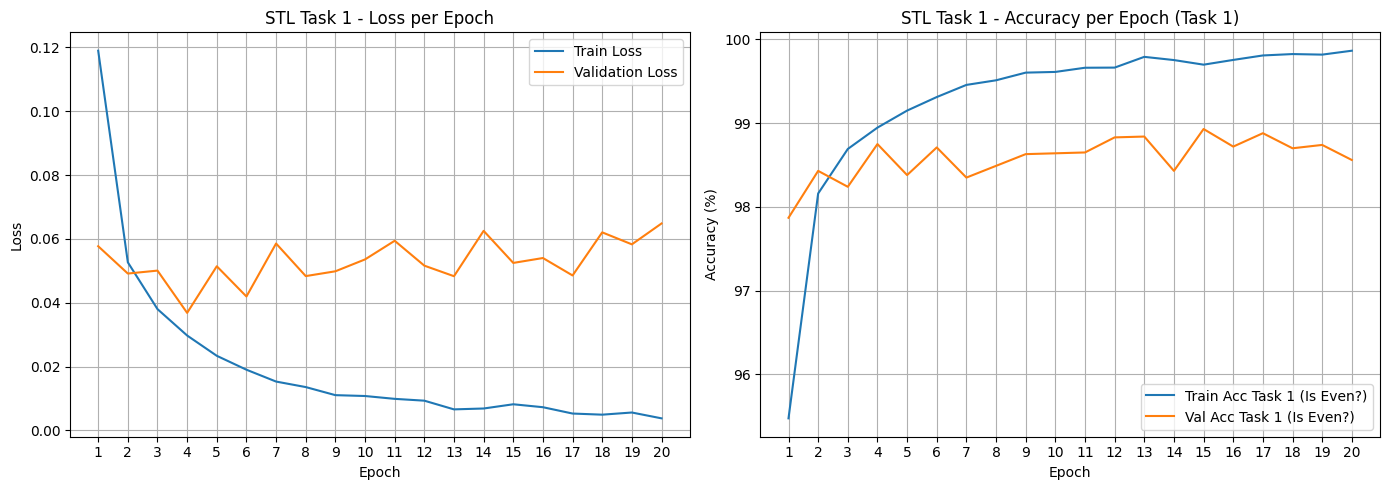

In [148]:
plot_training_history(history_stl_task1, "STL Task 1", tasks_involved=['task1'])

# Evaluate and plot confusion matrix for Task 1 on the best model
model_stl_task1.load_state_dict(torch.load('best_stl_task1_model.pth')) # torch.load: Loads a serialized object from disk (e.g., a saved model's state dictionary).
# Get final evaluation metrics
final_eval_stl_t1 = evaluate_model(model_stl_task1, test_loader, criterion, "STL_Task1")
# Store results
results['STL_Task1'] = {'accuracy': final_eval_stl_t1[1], 'time': time_stl_task1, 'params': sum(p.numel() for p in model_stl_task1.parameters() if p.requires_grad)}

In [149]:
print("\n--- Training STL for Task 2 (Is Multiple of 3?) ---")
# Initialize STL model for Task 2 and its optimizer
model_stl_task2 = STLModel(input_size, num_classes=1).to(device)
optimizer_stl_task2 = optim.Adam(model_stl_task2.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss() # Re-initialize for clarity, though it's the same loss function.

# Train the STL model for Task 2
history_stl_task2, time_stl_task2 = train_model(model_stl_task2, train_loader, optimizer_stl_task2, criterion, model_type="STL_Task2")


--- Training STL for Task 2 (Is Multiple of 3?) ---
Epoch 1/20 - Train Loss: 0.1435 - Train Acc T1: 0.00% - Train Acc T2: 94.30% - Val Loss: 0.0663 - Val Acc T1: 0.00% - Val Acc T2: 97.55%
Epoch 2/20 - Train Loss: 0.0621 - Train Acc T1: 0.00% - Train Acc T2: 97.81% - Val Loss: 0.0583 - Val Acc T1: 0.00% - Val Acc T2: 97.81%
Epoch 3/20 - Train Loss: 0.0456 - Train Acc T1: 0.00% - Train Acc T2: 98.40% - Val Loss: 0.0529 - Val Acc T1: 0.00% - Val Acc T2: 98.05%
Epoch 4/20 - Train Loss: 0.0355 - Train Acc T1: 0.00% - Train Acc T2: 98.76% - Val Loss: 0.0486 - Val Acc T1: 0.00% - Val Acc T2: 98.26%
Epoch 5/20 - Train Loss: 0.0302 - Train Acc T1: 0.00% - Train Acc T2: 98.91% - Val Loss: 0.0534 - Val Acc T1: 0.00% - Val Acc T2: 98.24%
Epoch 6/20 - Train Loss: 0.0226 - Train Acc T1: 0.00% - Train Acc T2: 99.20% - Val Loss: 0.0596 - Val Acc T1: 0.00% - Val Acc T2: 98.25%
Epoch 7/20 - Train Loss: 0.0192 - Train Acc T1: 0.00% - Train Acc T2: 99.33% - Val Loss: 0.0519 - Val Acc T1: 0.00% - Val Acc

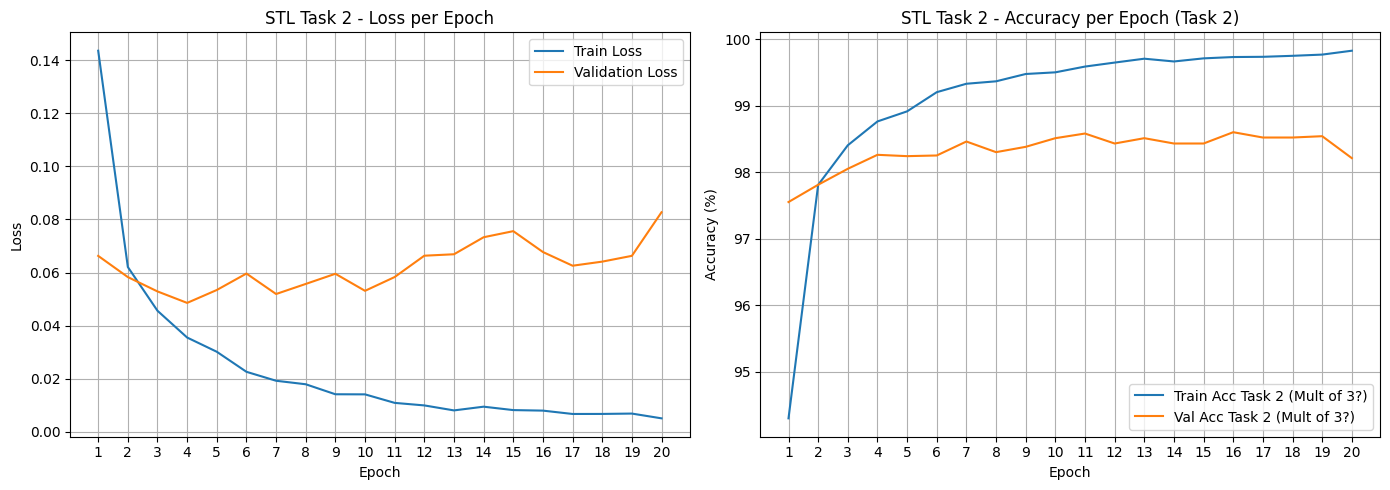

In [150]:
plot_training_history(history_stl_task2, "STL Task 2", tasks_involved=['task2'])
model_stl_task2.load_state_dict(torch.load('best_stl_task2_model.pth')) # Load the saved best model for Task 2.
# Get final evaluation metrics
final_eval_stl_t2 = evaluate_model(model_stl_task2, test_loader, criterion, "STL_Task2")
# Store results
results['STL_Task2'] = {'accuracy': final_eval_stl_t2[2], 'time': time_stl_task2, 'params': sum(p.numel() for p in model_stl_task2.parameters() if p.requires_grad)}

In [151]:
# 2. Hard Parameter Sharing Multi-Task Learning (MTL)
print("\n--- Training MTL with Hard Parameter Sharing ---")
# Initialize Hard Shared MLP model and its optimizer
model_mtl_hard = HardSharedMLP(input_size, num_classes_task1=1, num_classes_task2=1).to(device)
optimizer_mtl_hard = optim.Adam(model_mtl_hard.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Train the Hard Shared MTL model
history_mtl_hard, time_mtl_hard = train_model(model_mtl_hard, train_loader, optimizer_mtl_hard, criterion, model_type="MTL_Hard")


--- Training MTL with Hard Parameter Sharing ---
Epoch 1/20 - Train Loss: 0.2617 - Train Acc T1: 95.54% - Train Acc T2: 94.34% - Val Loss: 0.1249 - Val Acc T1: 97.92% - Val Acc T2: 97.78%
Epoch 2/20 - Train Loss: 0.1052 - Train Acc T1: 98.28% - Train Acc T2: 98.04% - Val Loss: 0.0973 - Val Acc T1: 98.49% - Val Acc T2: 98.28%
Epoch 3/20 - Train Loss: 0.0762 - Train Acc T1: 98.82% - Train Acc T2: 98.52% - Val Loss: 0.0920 - Val Acc T1: 98.56% - Val Acc T2: 98.29%
Epoch 4/20 - Train Loss: 0.0580 - Train Acc T1: 99.11% - Train Acc T2: 98.90% - Val Loss: 0.0940 - Val Acc T1: 98.62% - Val Acc T2: 98.37%
Epoch 5/20 - Train Loss: 0.0476 - Train Acc T1: 99.20% - Train Acc T2: 99.11% - Val Loss: 0.0773 - Val Acc T1: 98.93% - Val Acc T2: 98.58%
Epoch 6/20 - Train Loss: 0.0375 - Train Acc T1: 99.39% - Train Acc T2: 99.26% - Val Loss: 0.0887 - Val Acc T1: 98.78% - Val Acc T2: 98.50%
Epoch 7/20 - Train Loss: 0.0293 - Train Acc T1: 99.56% - Train Acc T2: 99.47% - Val Loss: 0.0942 - Val Acc T1: 98.74

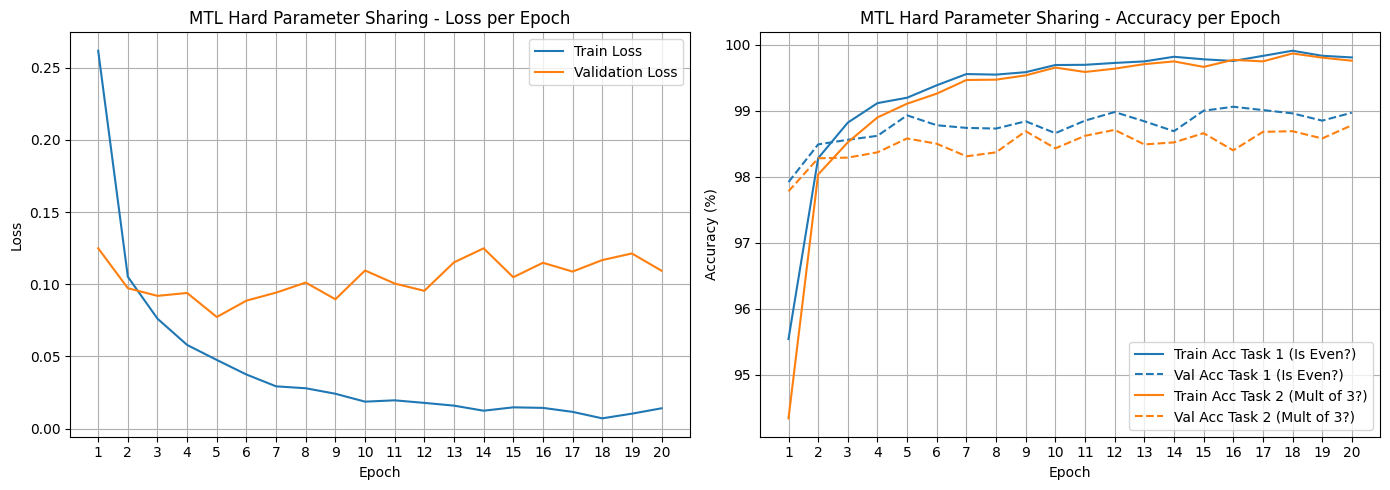

In [152]:
plot_training_history(history_mtl_hard, "MTL Hard Parameter Sharing")
model_mtl_hard.load_state_dict(torch.load('best_mtl_hard_model.pth')) # Load the saved best model.
# Get final evaluation metrics
final_eval_mtl_hard = evaluate_model(model_mtl_hard, test_loader, criterion, "MTL_Hard")
# Store results (note: time and params are common for both tasks in MTL models)
results['MTL_Hard_Task1'] = {'accuracy': final_eval_mtl_hard[1], 'time': time_mtl_hard, 'params': sum(p.numel() for p in model_mtl_hard.parameters() if p.requires_grad)}
results['MTL_Hard_Task2'] = {'accuracy': final_eval_mtl_hard[2], 'time': time_mtl_hard, 'params': sum(p.numel() for p in model_mtl_hard.parameters() if p.requires_grad)}

In [153]:
# 3. Cross-Stitch Networks (Soft Parameter Sharing) 
print("\n--- Training MTL with Cross-Stitch Networks ---")
# Initialize Cross-Stitch MLP model and its optimizer
model_mtl_cross = CrossStitchMLP(input_size, num_classes_task1=1, num_classes_task2=1).to(device)
optimizer_mtl_cross = optim.Adam(model_mtl_cross.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
history_mtl_cross, time_mtl_cross = train_model(model_mtl_cross, train_loader, optimizer_mtl_cross, criterion, model_type="MTL_CrossStitch")


--- Training MTL with Cross-Stitch Networks ---
Epoch 1/20 - Train Loss: 0.2739 - Train Acc T1: 95.31% - Train Acc T2: 94.06% - Val Loss: 0.1226 - Val Acc T1: 97.99% - Val Acc T2: 97.57%
Epoch 2/20 - Train Loss: 0.1066 - Train Acc T1: 98.34% - Train Acc T2: 98.01% - Val Loss: 0.1039 - Val Acc T1: 98.39% - Val Acc T2: 97.78%
Epoch 3/20 - Train Loss: 0.0744 - Train Acc T1: 98.83% - Train Acc T2: 98.65% - Val Loss: 0.0800 - Val Acc T1: 98.59% - Val Acc T2: 98.41%
Epoch 4/20 - Train Loss: 0.0554 - Train Acc T1: 99.09% - Train Acc T2: 98.96% - Val Loss: 0.0962 - Val Acc T1: 98.66% - Val Acc T2: 98.16%
Epoch 5/20 - Train Loss: 0.0422 - Train Acc T1: 99.34% - Train Acc T2: 99.20% - Val Loss: 0.0863 - Val Acc T1: 98.61% - Val Acc T2: 98.37%
Epoch 6/20 - Train Loss: 0.0349 - Train Acc T1: 99.44% - Train Acc T2: 99.32% - Val Loss: 0.0859 - Val Acc T1: 98.77% - Val Acc T2: 98.52%
Epoch 7/20 - Train Loss: 0.0280 - Train Acc T1: 99.53% - Train Acc T2: 99.46% - Val Loss: 0.0942 - Val Acc T1: 98.62%

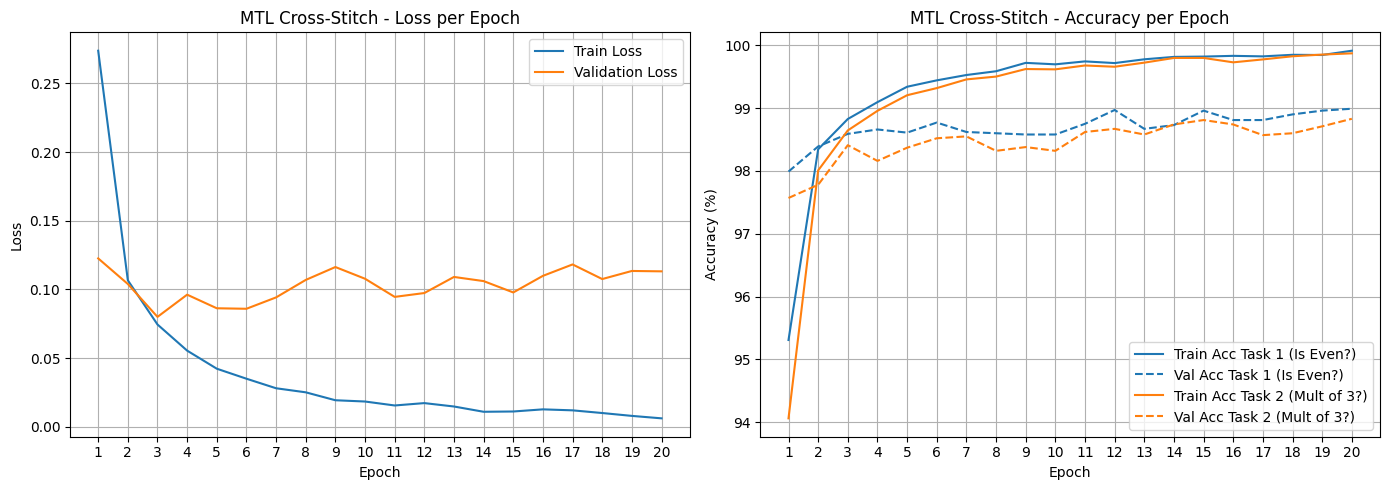

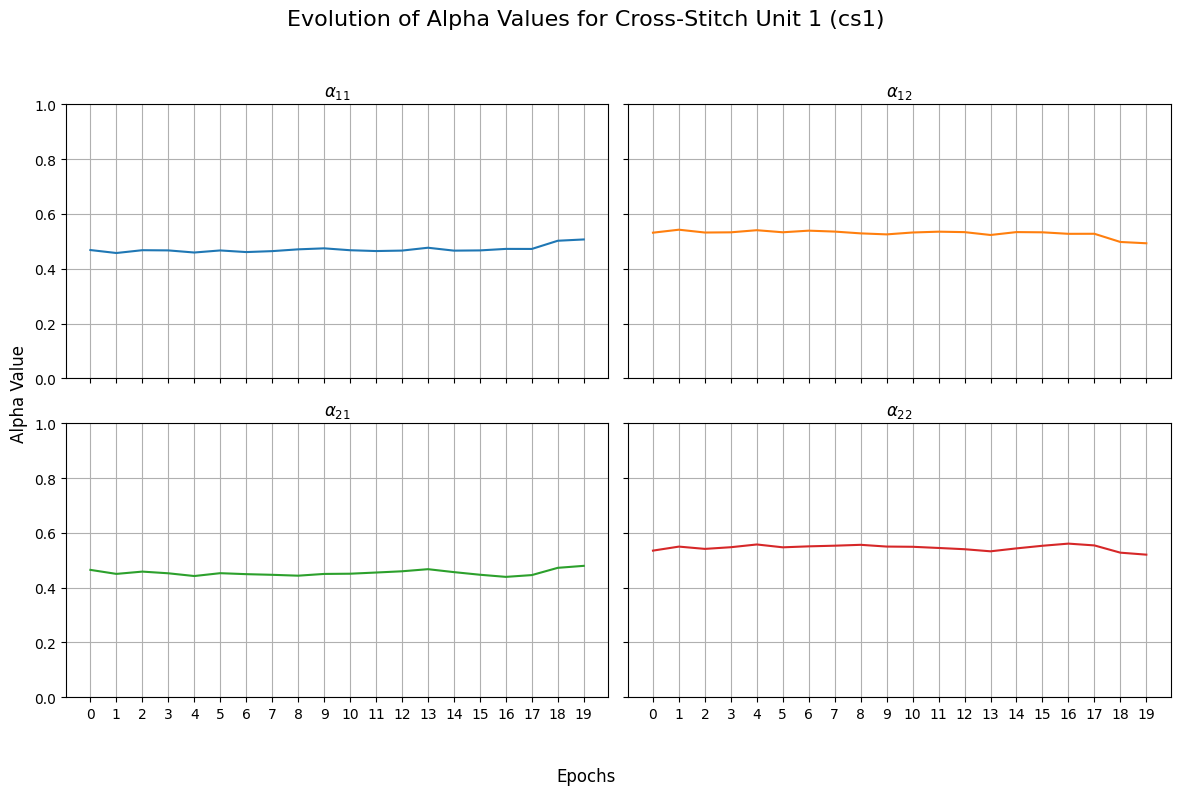

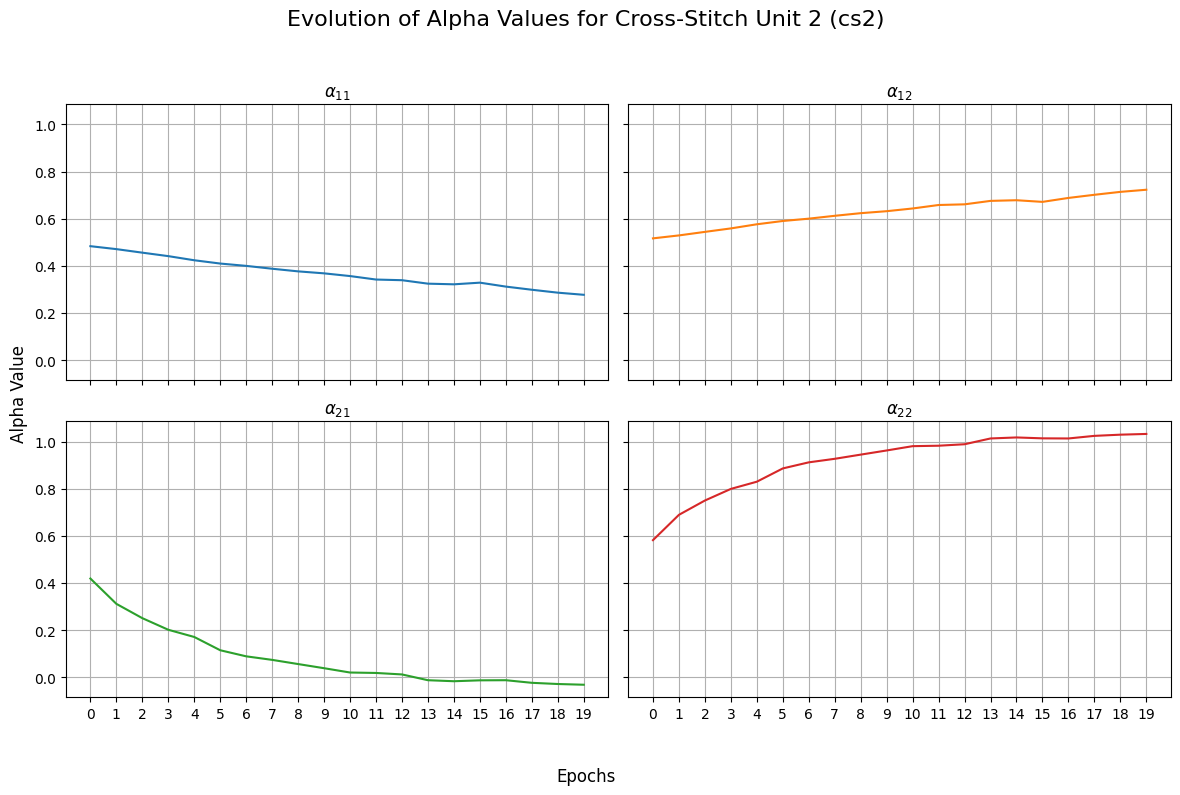

In [157]:
# Train the Cross-Stitch MTL model
plot_training_history(history_mtl_cross, "MTL Cross-Stitch")

if 'alphas' in history_mtl_cross and history_mtl_cross['alphas']:
    plot_alpha_values(
        alphas_history_dict=history_mtl_cross['alphas'], 
        num_epochs=NUM_EPOCHS,  
        unit_prefix="cs1",      
        unit_name_display="Cross-Stitch Unit 1 (cs1)",
    )
    
    if 'cs2_alpha00' in history_mtl_cross['alphas']: 
        plot_alpha_values(
            alphas_history_dict=history_mtl_cross['alphas'], 
            num_epochs=NUM_EPOCHS,  
            unit_prefix="cs2",      
            unit_name_display="Cross-Stitch Unit 2 (cs2)",
            limit=False  # Set to False to allow dynamic scaling of the y-axis
        )
    else:
        print("Alpha data for 'cs2' (Cross-Stitch Unit 2) not found in history.")
else:
    print("Alpha history ('alphas' key) not found in the training results for the Cross-Stitch model.")


# Evaluate and plot confusion matrices for Cross-Stitch on the best model
model_mtl_cross.load_state_dict(torch.load('best_mtl_crossstitch_model.pth')) # Load the saved best model.
# Get final evaluation metrics
final_eval_mtl_cross = evaluate_model(model_mtl_cross, test_loader, criterion, "MTL_CrossStitch")
# Store results
results['MTL_CrossStitch_Task1'] = {'accuracy': final_eval_mtl_cross[1], 'time': time_mtl_cross, 'params': sum(p.numel() for p in model_mtl_cross.parameters() if p.requires_grad)}
results['MTL_CrossStitch_Task2'] = {'accuracy': final_eval_mtl_cross[2], 'time': time_mtl_cross, 'params': sum(p.numel() for p in model_mtl_cross.parameters() if p.requires_grad)}

---

## 6. Summary of Results

This section presents a consolidated table summarizing the performance metrics (accuracy, training time, and number of learnable parameters) for all trained models.

In [155]:
# --- Summary of Results ---
print("\n--- Summary of Results ---")

table_data = []

processed_mtl_models = set()

for model_key, metrics in results.items():
    model_type_display = model_key.rsplit('_Task', 1)[0] 
    task_name = "Task 1 (Is Even?)" if "Task1" in model_key else "Task 2 (Is Multiple of 3?)"

    if model_type_display.startswith("STL"):
        table_data.append({
            "Model Type": model_type_display,
            "Task": task_name,
            "Accuracy (%)": f"{metrics.get('accuracy', 0.0):.2f}",
            "Training Time (s)": f"{metrics.get('time', 0.0):.2f}",
            "Learnable Parameters": f"{metrics.get('params', 0):,}" 
        })
    else: 
        if model_type_display not in processed_mtl_models:
            
            mtl_task1_key = f'{model_type_display}_Task1'
            mtl_task2_key = f'{model_type_display}_Task2'
            
            task1_metrics = results.get(mtl_task1_key, {})
            task2_metrics = results.get(mtl_task2_key, {})

            training_time_mtl = task1_metrics.get('time', results.get(mtl_task2_key, {}).get('time', 0.0))
            params_mtl = task1_metrics.get('params', results.get(mtl_task2_key, {}).get('params', 0))

            table_data.append({
                "Model Type": model_type_display,
                "Task": "Task 1 (Is Even?)",
                "Accuracy (%)": f"{task1_metrics.get('accuracy', 0.0):.2f}",
                "Training Time (s)": f"{training_time_mtl:.2f}", 
                "Learnable Parameters": f"{params_mtl:,}" 
            })
            table_data.append({
                "Model Type": "", 
                "Task": "Task 2 (Is Multiple of 3?)",
                "Accuracy (%)": f"{task2_metrics.get('accuracy', 0.0):.2f}",
                "Training Time (s)": "-",
                "Learnable Parameters": "-" 
            })
            processed_mtl_models.add(model_type_display)

df_results = pd.DataFrame(table_data, columns=["Model Type", "Task", "Accuracy (%)", "Training Time (s)", "Learnable Parameters"])
print(df_results.to_markdown(index=False, tablefmt="pipe")) 


--- Summary of Results ---
| Model Type      | Task                       |   Accuracy (%) | Training Time (s)   | Learnable Parameters   |
|:----------------|:---------------------------|---------------:|:--------------------|:-----------------------|
| STL             | Task 1 (Is Even?)          |          98.93 | 300.17              | 233,985                |
| STL             | Task 2 (Is Multiple of 3?) |          98.6  | 299.09              | 233,985                |
| MTL_Hard        | Task 1 (Is Even?)          |          98.97 | 301.49              | 234,114                |
|                 | Task 2 (Is Multiple of 3?) |          98.78 | -                   | -                      |
| MTL_CrossStitch | Task 1 (Is Even?)          |          98.99 | 354.03              | 467,978                |
|                 | Task 2 (Is Multiple of 3?) |          98.83 | -                   | -                      |


### Conclusion
#### Analysis of Results

**1. Performance and Accuracy**

The results of this experiment suggest a potential advantage in using Multi-Task Learning architectures. Both MTL models achieved slightly higher performance than the STL baseline on both tasks.

* The **MTL_Hard** model provided encouraging results, improving accuracy over STL on both tasks (+0.04% on Task 1, +0.18% on Task 2). This, combined with its notable efficiency, makes it a solution with a good cost-benefit ratio.
* The **MTL_CrossStitch** model achieved the highest accuracy, but its margin of improvement over MTL_Hard appears modest (+0.02% on Task 1, +0.05% on Task 2), especially when considering its higher computational cost.

**2. Computational Efficiency**

The **MTL_Hard** approach stands out as the most efficient, nearly halving the number of parameters and the training time compared to training two STL models. The **MTL_CrossStitch** approach remains the most expensive solution in terms of parameters and computation time.

#### Analysis of Cross-Stitch Alpha Values

The plots of the alpha parameters offer an interesting indication of how the Cross-Stitch model might have managed the information flow between tasks at different network layers.

* **Cross-Stitch Unit 1 (Early Layer):** In this layer, the alpha values settle around 0.5. This suggests that for low-level features, the model seems to have learned that a balanced mix of information from both tasks could be an effective strategy.

* **Cross-Stitch Unit 2 (Later Layer):** Here, a more specialized behavior is observed. The parameters indicate that the contribution from Task 2's features tends to decrease (${\alpha_{21}}$ approaches zero), while the model learns to rely more heavily on features from Task 1 (${\alpha_{22}}$ approaches 1.0). This suggests that the features from the "Is Even?" branch may have been deemed more informative for the second task at this stage of the network.

This behavior indicates the capacity of soft sharing to learn complex sharing strategies, dynamically adapting the flow of information between tasks.

#### Final Considerations

For this specific problem, the results suggest that **Multi-Task Learning architectures may offer benefits** in both accuracy and efficiency compared to training single models.

The **MTL_Hard model appears to offer the best overall compromise**, providing a slight performance improvement at a significantly lower computational cost.

The **MTL_CrossStitch** model, while being the most accurate, shows a marginal gain that might not justify the increase in complexity and cost. Its value in this context appears to be mainly didactic: the analysis of the alpha parameters indicated a possible complex and adaptive learning strategy, even though this did not translate into a substantial accuracy gain in this use case.